In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import transformers
import pandas as pd
from pprint import pprint
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import time
import datetime

In [2]:
device = 0 if torch.cuda.is_available() else -1
batch_size = 32
max_length = 128

In [3]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [4]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Data

In [5]:
go_emotions_path = "data/goemotions"

train = pd.read_csv(f"{go_emotions_path}/train.tsv",sep='\t')
test = pd.read_csv(f"{go_emotions_path}/test.tsv",sep='\t')


In [6]:
emotion_dict = {
    "admiração": 0,
    "diversão": 1,
    "raiva": 2,
    "aborrecimento": 3,
    "aprovação": 4,
    "zelo": 5,
    "confusão": 6,
    "curiosidade": 7,
    "desejo": 8,
    "decepção": 9,
    "desaprovação": 10,
    "nojo": 11,
    "constrangimento": 12,
    "entusiasmo": 13,
    "medo": 14,
    "gratidão": 15,
    "luto": 16,
    "alegria": 17,
    "amor": 18,
    "nervosismo": 19,
    "otimismo": 20,
    "orgulho": 21,
    "percepção": 22,
    "alívio": 23,
    "remorso": 24,
    "tristeza": 25,
    "surpresa": 26,
    "neutro": 27
}

In [7]:
def change_label_encoding(row):
    labels = row['labels'].replace(" ","").split(",")
    new_row = {}
    for emotion in emotion_dict:
        if str(emotion_dict[emotion]) in labels:
            new_row[emotion] = True
        else:
            new_row[emotion] = False
    return new_row
        

In [8]:
train_labels = pd.DataFrame(list(train.apply(change_label_encoding,axis=1)))
test_labels = pd.DataFrame(list(test.apply(change_label_encoding,axis=1)))


In [9]:
train_inputs = list(train.text.apply(lambda x: x[:512] if len(x) > 512 else x))
test_inputs = list(test.text.apply(lambda x: x[:512] if len(x) > 512 else x))


# Teacher model

In [10]:
model_path = 'models/go_emotions'

model = transformers.BertForSequenceClassification.from_pretrained(model_path)
tokenizer = transformers.BertTokenizer.from_pretrained(model_path)

classifier = transformers.pipeline('text-classification', model=model, tokenizer=tokenizer, return_all_scores=True,device=device)

threshold = 0.3

/home/augusto/miniconda3/envs/ganbert/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [11]:
output = classifier(test_inputs)


#for prediction in output:

#	predictions.append(list(x for x in prediction if x['score']>= threshold))

#new = []
#for dic in predictions:
#  temp = {}
#  for prediction in dic:
#    temp[prediction['label']] = prediction['score']
#  new.append(temp)

In [12]:
predictions = []
for prediction in output:
    row = {}
    for x in prediction:
        if x['score'] >= threshold:
            row[x['label']] = True
        else:
            row[x['label']] = False
    predictions.append(row)
predictions = pd.DataFrame(predictions)

<AxesSubplot:>

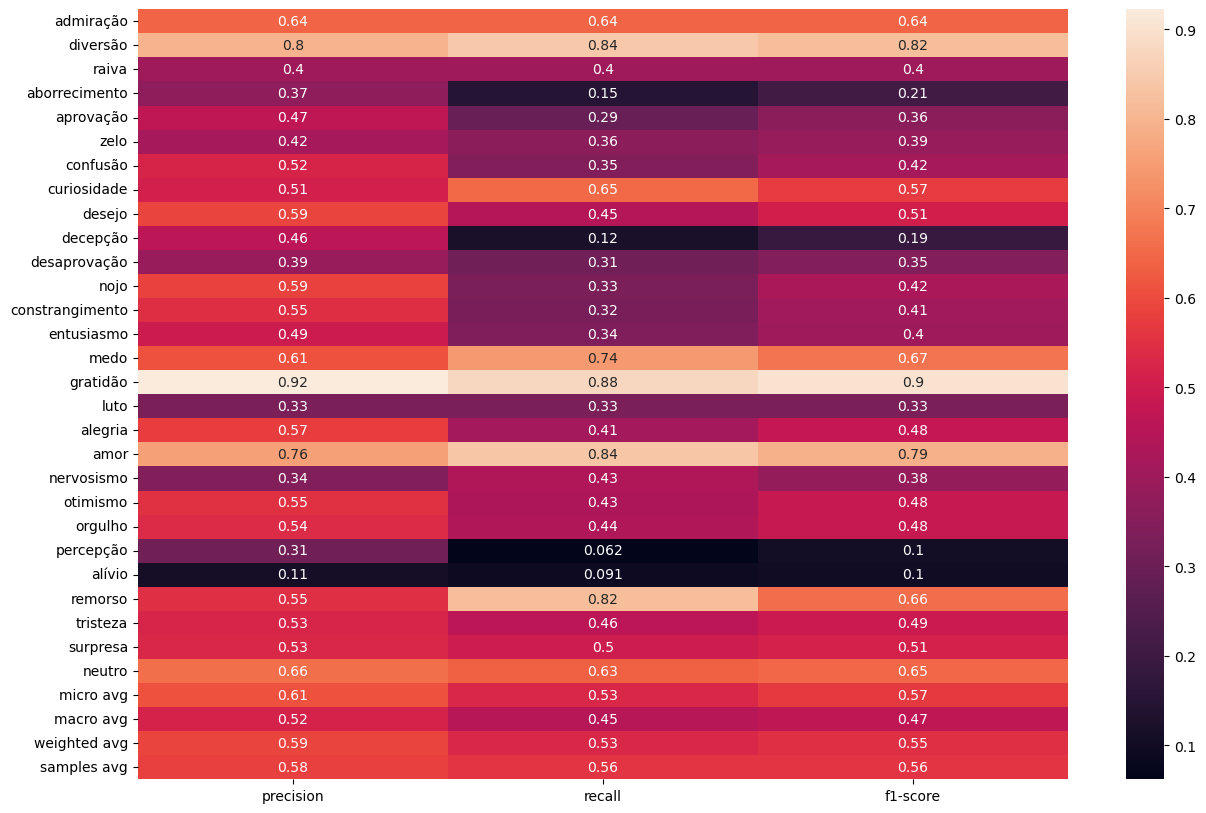

In [13]:
clf_report = classification_report(np.array(test_labels),np.array(predictions),target_names=test_labels.columns,output_dict=True,zero_division=0)

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [14]:
keep = pd.DataFrame(clf_report).T['f1-score'][:-4] >= 0.4

keep.to_csv("data/emotions_to_keep.csv")
    

# Student Models

## Basic model compression (using logits directly)

In [15]:
#getting the logits
def get_logits(inputs):
    logits = []
    for i,example in enumerate(inputs):
    
        if i % 10000 == 0:
            print(f"{i} de {len(inputs)}")
        encoding = tokenizer.encode_plus(
            example,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
        with torch.no_grad():
            input_ids = encoding['input_ids'].to(device)
            mask = encoding['attention_mask'].to(device)
            outputs = model(input_ids,attention_mask = mask)
            logit = outputs.logits.squeeze(-2)
            del outputs
    
            del input_ids
            del mask
    
            logits.append(logit)
            del logit
    return logits
    


#output = model(teste)

In [16]:
logits = get_logits(train_inputs)
train_logits = torch.stack(logits)

0 de 43410
10000 de 43410
20000 de 43410
30000 de 43410
40000 de 43410


In [17]:
logits = get_logits(test_inputs)
test_logits = torch.stack(logits)

0 de 5427


In [18]:
model_name = 'neuralmind/bert-base-portuguese-cased'
student_model = transformers.BertForSequenceClassification.from_pretrained(model_name,num_labels=len(emotion_dict))
student_tokenizer = transformers.BertTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [19]:
def generate_student_dataloader(examples,tokenizer,teacher_logits,batch_size=32):
    inputs = []
    attention_masks = []
    for text in examples:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        inputs.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
        
    inputs = torch.stack(inputs)
    attention_masks = torch.stack(attention_masks)

    dataset = TensorDataset(inputs, attention_masks,teacher_logits)
    student_dataloader = DataLoader(
              dataset,
              sampler = SequentialSampler(dataset), 
              batch_size = batch_size)
        
    return student_dataloader

In [20]:
train_dataloader = generate_student_dataloader(train_inputs,student_tokenizer,train_logits,batch_size)
test_dataloader = generate_student_dataloader(test_inputs,student_tokenizer,test_logits,batch_size)

In [21]:
#parâmetros de treinamento para esse modelo

num_train_epochs = 4
learning_rate = 5e-5
apply_scheduler = True
warmup_proportion = 0.1
print_each_n_step = 100


In [22]:
student_model = student_model.to(device)

In [23]:
#models parameters
transformer_vars = [i for i in student_model.parameters()]

#optimizer
optimizer = torch.optim.AdamW(transformer_vars, lr=learning_rate)

#loss
loss_func = torch.nn.MSELoss()

#scheduler
if apply_scheduler:
  num_train_examples = len(train_inputs)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler = transformers.get_constant_schedule_with_warmup(optimizer, 
                                           num_warmup_steps = num_warmup_steps)


for epoch_i in range(num_train_epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')
    
    t0 = time.time()
    tr_loss = 0
    
    student_model.train()
    
    for step,batch in enumerate(train_dataloader):
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[0]),max_length)
        b_teacher_logits = batch[2].to(device)
        
        model_outputs = student_model(b_input_ids,attention_mask=b_attention_mask).logits.to(device)
        
        batch_loss = loss_func(model_outputs,b_teacher_logits)
        
        optimizer.zero_grad()
        
        batch_loss.backward()
        
        optimizer.step()
        
        tr_loss += batch_loss
        
        if apply_scheduler:
            scheduler.step()
            
    avg_train_loss = tr_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    student_model.eval()
    total_test_loss = 0
    t0 = time.time()
    
    for step,batch in enumerate(test_dataloader):
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[0]),max_length)
        b_teacher_logits = batch[2].to(device)
        
        with torch.no_grad():
            model_outputs = student_model(b_input_ids,attention_mask=b_attention_mask).logits.to(device)
            total_test_loss += loss_func(model_outputs,b_teacher_logits)
    avg_test_loss = total_test_loss / len(test_dataloader)
    
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

        
    
        


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  1,357.    Elapsed: 0:00:18.
  Batch   200  of  1,357.    Elapsed: 0:00:35.
  Batch   300  of  1,357.    Elapsed: 0:00:53.
  Batch   400  of  1,357.    Elapsed: 0:01:11.
  Batch   500  of  1,357.    Elapsed: 0:01:28.
  Batch   600  of  1,357.    Elapsed: 0:01:46.
  Batch   700  of  1,357.    Elapsed: 0:02:04.
  Batch   800  of  1,357.    Elapsed: 0:02:21.
  Batch   900  of  1,357.    Elapsed: 0:02:39.
  Batch 1,000  of  1,357.    Elapsed: 0:02:56.
  Batch 1,100  of  1,357.    Elapsed: 0:03:14.
  Batch 1,200  of  1,357.    Elapsed: 0:03:32.
  Batch 1,300  of  1,357.    Elapsed: 0:03:49.
  Average training loss: 3.130
  Training epoch took: 0:03:59
  Test Loss: 0.261
  Test took: 0:00:09

======== Epoch 2 / 4 ========
Training...
  Batch   100  of  1,357.    Elapsed: 0:00:18.
  Batch   200  of  1,357.    Elapsed: 0:00:35.
  Batch   300  of  1,357.    Elapsed: 0:00:53.
  Batch   400  of  1,357.    Elapsed: 0:01:11.
  Batch   500

In [24]:
#get probabilities
student_model.eval()
softmax = torch.nn.Softmax()
predictions = []
for step,batch in enumerate(test_dataloader):
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[0]),max_length)
        b_teacher_logits = batch[2].to(device)
        
        with torch.no_grad():
            model_outputs = student_model(b_input_ids,attention_mask=b_attention_mask).logits.to(device)                
            for b_pred in (softmax(model_outputs).detach().cpu() > threshold):
                predictions.append(b_pred)
predictions = torch.stack(predictions) 

/tmp/ipykernel_233579/3263373371.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  for b_pred in (softmax(model_outputs).detach().cpu() > threshold):


<AxesSubplot:>

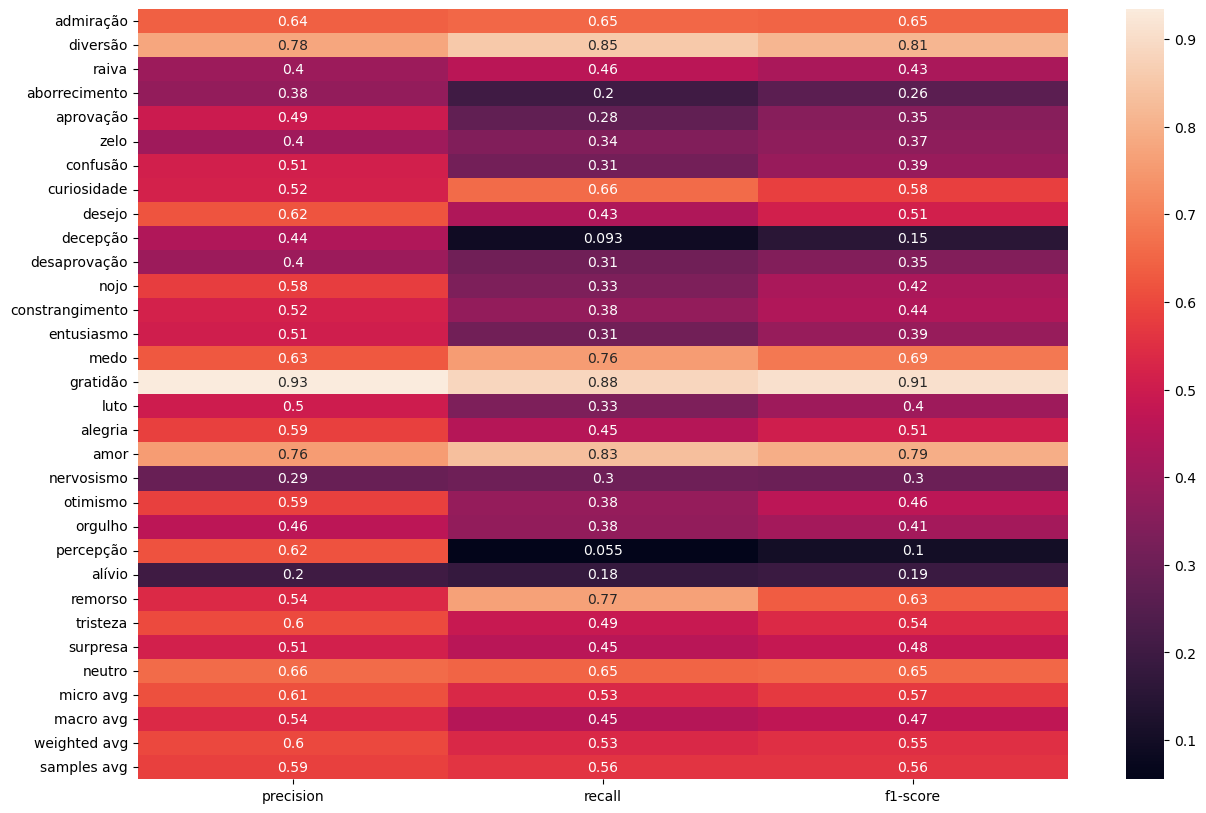

In [25]:
basic_compression_results = classification_report(np.array(test_labels),np.array(predictions),target_names=test_labels.columns,output_dict=True,zero_division=0)

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(basic_compression_results).iloc[:-1, :].T, annot=True)

## Comparando resultados

<AxesSubplot:>

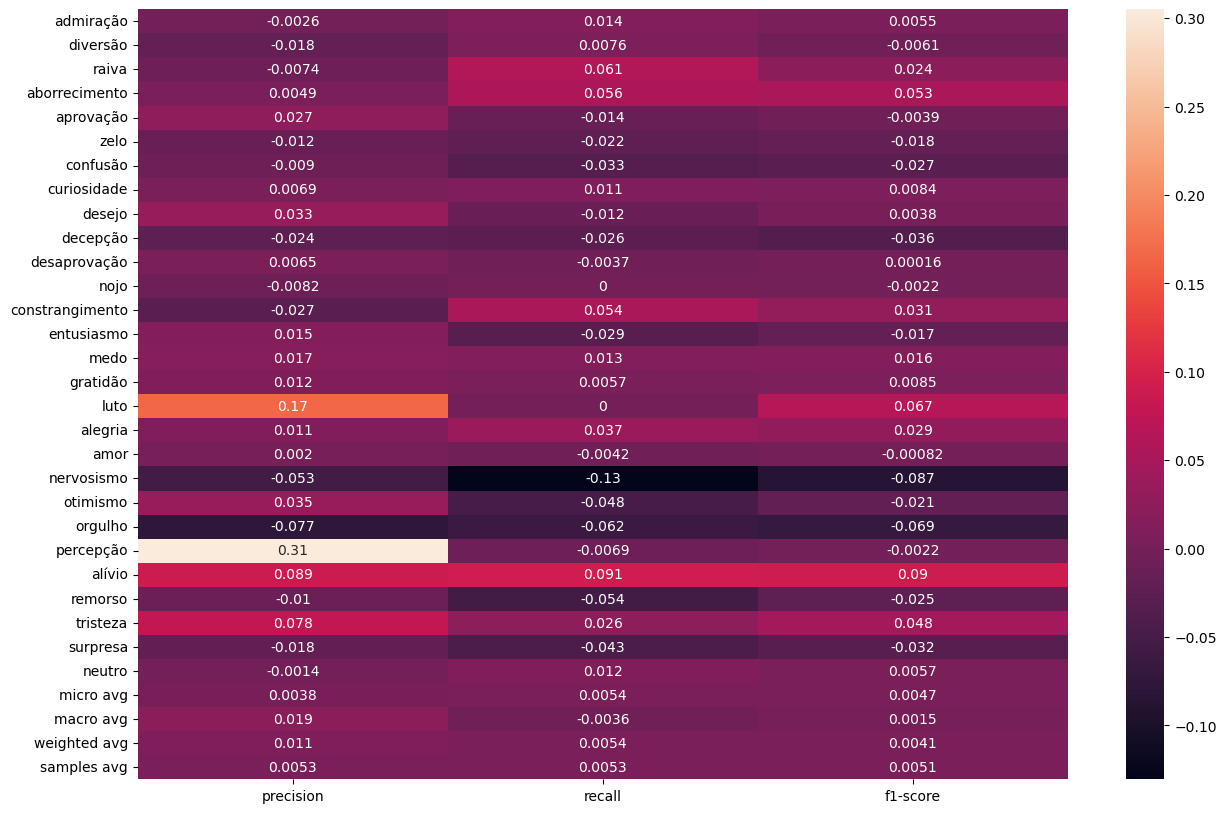

In [26]:
#leve perdas, leves ganhos, funciona!
#muitos ganhos em "luto" por qualquer motivo

diff = pd.DataFrame(basic_compression_results).iloc[:-1, :] - pd.DataFrame(clf_report).iloc[:-1, :]
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(diff).T, annot=True)

## Basic model distillation (KL-Loss com temp)



In [27]:
#demonstrando que temperatura produz distribuições mais suaves de probs
T = 3
teste = train_logits[0]/T
#NOTA: lembrar de usar temp 1 nos testes


In [28]:
del student_model
del student_tokenizer

In [29]:
model_name = 'neuralmind/bert-base-portuguese-cased'
student_model = transformers.BertForSequenceClassification.from_pretrained(model_name,num_labels=len(emotion_dict))
student_tokenizer = transformers.BertTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [30]:
student_model = student_model.to(device)

In [31]:
T = 3
#models parameters
transformer_vars = [i for i in student_model.parameters()]

#optimizer
optimizer = torch.optim.AdamW(transformer_vars, lr=learning_rate)

#loss
loss_func = torch.nn.KLDivLoss(reduction="batchmean")
#scheduler
if apply_scheduler:
  num_train_examples = len(train_inputs)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler = transformers.get_constant_schedule_with_warmup(optimizer, 
                                           num_warmup_steps = num_warmup_steps)
for epoch_i in range(num_train_epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')
    
    t0 = time.time()
    tr_loss = 0
    
    student_model.train()
    
    for step,batch in enumerate(train_dataloader):

        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[0]),max_length)
        b_teacher_logits = batch[2].to(device)/T
        
        #se der errado pode ser essa linha abaixo o problema
        model_outputs = student_model(b_input_ids,attention_mask=b_attention_mask).logits.to(device)/T
        #tem que ser log_softmax. Entender o por quê. Knowledge is power etc. etc.
        student_output = torch.nn.functional.log_softmax(model_outputs)
        teacher_output = torch.nn.functional.softmax(b_teacher_logits)
        
        batch_loss = loss_func(student_output,teacher_output)
        
        optimizer.zero_grad()
        
        batch_loss.backward()
        
        optimizer.step()
        
        tr_loss += batch_loss
        
        if apply_scheduler:
            scheduler.step()
            
    avg_train_loss = tr_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    student_model.eval()
    total_test_loss = 0
    t0 = time.time()
    
    for step,batch in enumerate(test_dataloader):
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[0]),max_length)
        b_teacher_logits = batch[2].to(device)/T
        
        with torch.no_grad():
            model_outputs = student_model(b_input_ids,attention_mask=b_attention_mask).logits.to(device)/T
            student_output = torch.nn.functional.log_softmax(model_outputs)
            teacher_output = torch.nn.functional.softmax(b_teacher_logits)
            total_test_loss += loss_func(student_output,teacher_output)
    avg_test_loss = total_test_loss / len(test_dataloader)
    
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))


======== Epoch 1 / 4 ========
Training...


/tmp/ipykernel_233579/4271550677.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(model_outputs)
/tmp/ipykernel_233579/4271550677.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Batch   100  of  1,357.    Elapsed: 0:00:18.
  Batch   200  of  1,357.    Elapsed: 0:00:35.
  Batch   300  of  1,357.    Elapsed: 0:00:53.
  Batch   400  of  1,357.    Elapsed: 0:01:11.
  Batch   500  of  1,357.    Elapsed: 0:01:28.
  Batch   600  of  1,357.    Elapsed: 0:01:46.
  Batch   700  of  1,357.    Elapsed: 0:02:04.
  Batch   800  of  1,357.    Elapsed: 0:02:21.
  Batch   900  of  1,357.    Elapsed: 0:02:39.
  Batch 1,000  of  1,357.    Elapsed: 0:02:57.
  Batch 1,100  of  1,357.    Elapsed: 0:03:14.
  Batch 1,200  of  1,357.    Elapsed: 0:03:32.
  Batch 1,300  of  1,357.    Elapsed: 0:03:49.
  Average training loss: 0.058
  Training epoch took: 0:04:00


/tmp/ipykernel_233579/4271550677.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(model_outputs)
/tmp/ipykernel_233579/4271550677.py:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Test Loss: 0.011
  Test took: 0:00:09

======== Epoch 2 / 4 ========
Training...
  Batch   100  of  1,357.    Elapsed: 0:00:18.
  Batch   200  of  1,357.    Elapsed: 0:00:35.
  Batch   300  of  1,357.    Elapsed: 0:00:53.
  Batch   400  of  1,357.    Elapsed: 0:01:11.
  Batch   500  of  1,357.    Elapsed: 0:01:28.
  Batch   600  of  1,357.    Elapsed: 0:01:46.
  Batch   700  of  1,357.    Elapsed: 0:02:04.
  Batch   800  of  1,357.    Elapsed: 0:02:21.
  Batch   900  of  1,357.    Elapsed: 0:02:39.
  Batch 1,000  of  1,357.    Elapsed: 0:02:57.
  Batch 1,100  of  1,357.    Elapsed: 0:03:14.
  Batch 1,200  of  1,357.    Elapsed: 0:03:32.
  Batch 1,300  of  1,357.    Elapsed: 0:03:49.
  Average training loss: 0.012
  Training epoch took: 0:04:00
  Test Loss: 0.009
  Test took: 0:00:09

======== Epoch 3 / 4 ========
Training...
  Batch   100  of  1,357.    Elapsed: 0:00:18.
  Batch   200  of  1,357.    Elapsed: 0:00:35.
  Batch   300  of  1,357.    Elapsed: 0:00:53.
  Batch   400  of  1

In [32]:
#get probabilities
student_model.eval()
softmax = torch.nn.Softmax()
predictions = []
for step,batch in enumerate(test_dataloader):
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[0]),max_length)
        b_teacher_logits = batch[2].to(device)
        
        with torch.no_grad():
            model_outputs = student_model(b_input_ids,attention_mask=b_attention_mask).logits.to(device)                
            for b_pred in (softmax(model_outputs).detach().cpu() > threshold):
                predictions.append(b_pred)
predictions = torch.stack(predictions) 

/tmp/ipykernel_233579/3263373371.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  for b_pred in (softmax(model_outputs).detach().cpu() > threshold):


<AxesSubplot:>

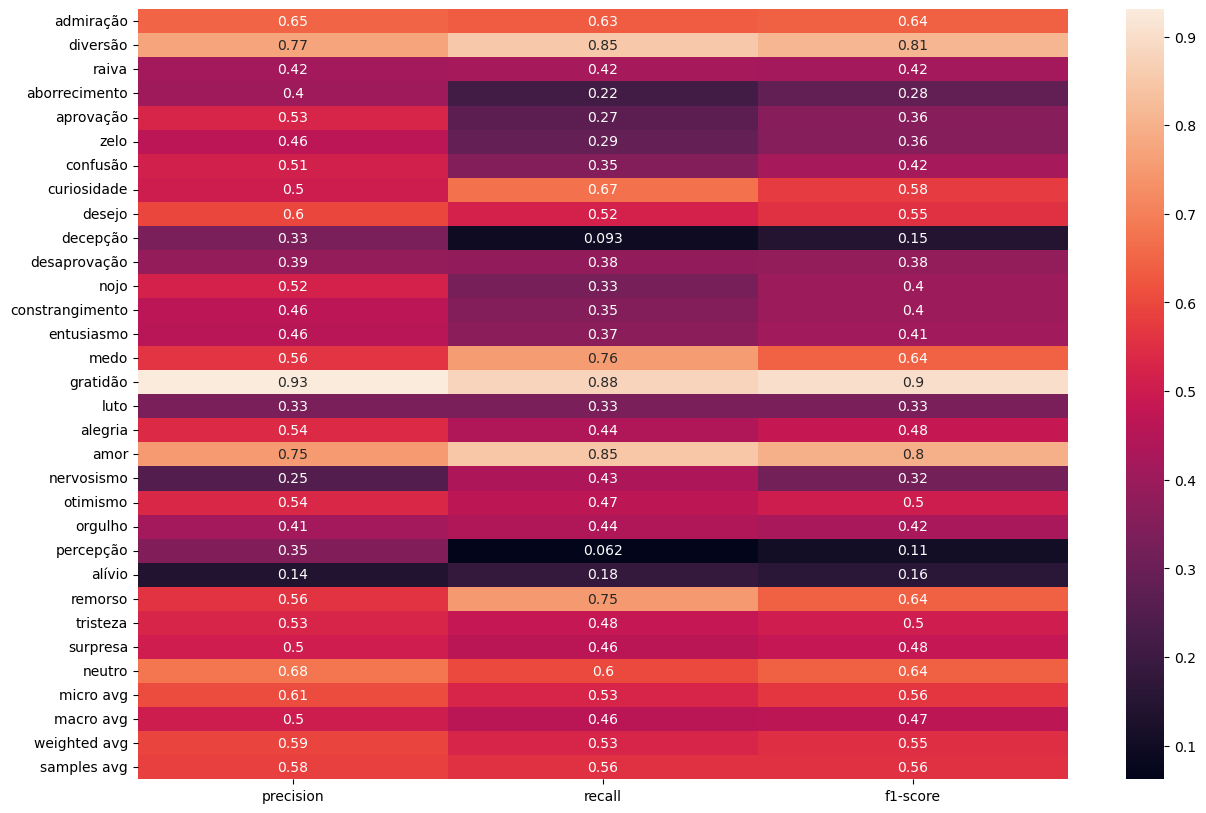

In [33]:
basic_kd_results = classification_report(np.array(test_labels),np.array(predictions),target_names=test_labels.columns,output_dict=True,zero_division=0)

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(basic_kd_results).iloc[:-1, :].T, annot=True)

<AxesSubplot:>

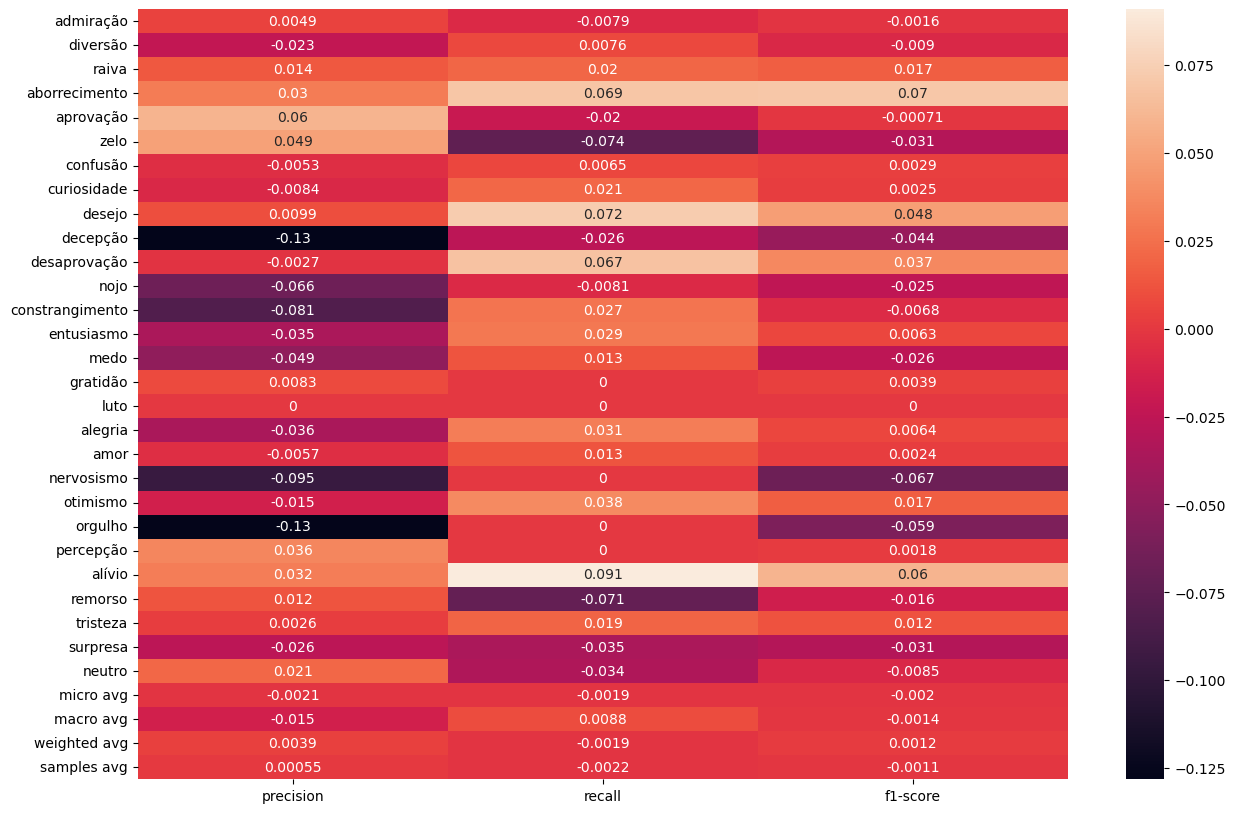

In [34]:
#melhor que o model compression! Acho que vale a pena usar
diff = pd.DataFrame(basic_kd_results).iloc[:-1, :] - pd.DataFrame(clf_report).iloc[:-1, :]
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(diff).T, annot=True)

# checando knowledge distillation pro conjunto do face.

É possível aprender alguma coisa?

In [35]:
df = pd.read_csv("features/goemotions facebook_sentences.csv")
aux = pd.read_csv("data/segredos_sentenças_multitask_clean.csv",index_col=0)

aux = aux.drop(["Postagem com possível perfil depressivo","Alteração na eficiência",
         "Alteração da funcionalidade","*",'Agitação/inquietação','Sintoma obsessivo e compulsivo','Déficit de atenção/Memória',
              'Perda/Diminuição do prazer/ Perda/Diminuição da libido'],axis=1)
remove_neutral_instances = True

In [36]:
from skmultilearn.skmultilearn.model_selection.iterative_stratification import iterative_train_test_split

if remove_neutral_instances == True:
    aux = aux.reset_index(drop=True)
    aux = aux[aux.iloc[:,1:].sum(axis=1) != 0]
    
aux = aux.reset_index(drop=True)
df = df.reset_index(drop=True)

train_df,_,test_df, _ = iterative_train_test_split(aux,aux.iloc[:,1:],test_size=0.5)

train_inputs = df.loc[train_df.index].text
test_inputs = df.loc[test_df.index].text

train_logits = df.loc[train_df.index]
test_logits = df.loc[test_df.index]

In [37]:
train_logits =train_logits.iloc[:,:-1]
test_logits =test_logits.iloc[:,:-1]

In [38]:
#model_name = 'neuralmind/bert-base-portuguese-cased'
model_name = 'models/go_emotions'

student_model = transformers.BertForSequenceClassification.from_pretrained(model_name,num_labels=len(emotion_dict))
student_tokenizer = transformers.BertTokenizer.from_pretrained(model_name)

In [39]:
student_model = student_model.to(device)

In [40]:
train_dataloader = generate_student_dataloader(train_inputs,student_tokenizer,torch.tensor(train_logits.to_numpy()),batch_size)


In [41]:
T = 3
#models parameters
transformer_vars = [i for i in student_model.parameters()]
num_train_epochs =20
#optimizer
optimizer = torch.optim.AdamW(transformer_vars, lr=learning_rate)

#loss
loss_func = torch.nn.KLDivLoss(reduction="batchmean")

#scheduler
if apply_scheduler:
  num_train_examples = len(train_inputs)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler = transformers.get_constant_schedule_with_warmup(optimizer, 
                                           num_warmup_steps = num_warmup_steps)
for epoch_i in range(num_train_epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')
    
    t0 = time.time()
    tr_loss = 0
    
    student_model.train()
    
    for step,batch in enumerate(train_dataloader):

        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[0]),max_length)
        b_teacher_logits = batch[2].to(device)/T
        
        #se der errado pode ser essa linha abaixo o problema
        model_outputs = student_model(b_input_ids,attention_mask=b_attention_mask).logits.to(device)/T
        #tem que ser log_softmax. Entender o por quê. Knowledge is power etc. etc.
        student_output = torch.nn.functional.log_softmax(model_outputs)
        teacher_output = torch.nn.functional.softmax(b_teacher_logits)
        
        batch_loss = loss_func(student_output,teacher_output)
        
        optimizer.zero_grad()
        
        batch_loss.backward()
        
        optimizer.step()
        
        tr_loss += batch_loss
        
        if apply_scheduler:
            scheduler.step()
            
    avg_train_loss = tr_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    student_model.eval()
    total_test_loss = 0
    t0 = time.time()
    
    for step,batch in enumerate(test_dataloader):
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[0]),max_length)
        b_teacher_logits = batch[2].to(device)/T
        
        with torch.no_grad():
            model_outputs = student_model(b_input_ids,attention_mask=b_attention_mask).logits.to(device)/T
            student_output = torch.nn.functional.log_softmax(model_outputs)
            teacher_output = torch.nn.functional.softmax(b_teacher_logits)
            total_test_loss += loss_func(student_output,teacher_output)
    avg_test_loss = total_test_loss / len(test_dataloader)
    
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))


======== Epoch 1 / 20 ========
Training...


/tmp/ipykernel_233579/1142844265.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(model_outputs)
/tmp/ipykernel_233579/1142844265.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Average training loss: 0.007
  Training epoch took: 0:00:05


/tmp/ipykernel_233579/1142844265.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(model_outputs)
/tmp/ipykernel_233579/1142844265.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Test Loss: 0.001
  Test took: 0:00:09

======== Epoch 2 / 20 ========
Training...
  Average training loss: 0.009
  Training epoch took: 0:00:04
  Test Loss: 0.004
  Test took: 0:00:09

======== Epoch 3 / 20 ========
Training...
  Average training loss: 0.015
  Training epoch took: 0:00:04
  Test Loss: 0.010
  Test took: 0:00:09

======== Epoch 4 / 20 ========
Training...
  Average training loss: 0.014
  Training epoch took: 0:00:04
  Test Loss: 0.005
  Test took: 0:00:09

======== Epoch 5 / 20 ========
Training...
  Average training loss: 0.009
  Training epoch took: 0:00:04
  Test Loss: 0.008
  Test took: 0:00:09

======== Epoch 6 / 20 ========
Training...
  Average training loss: 0.008
  Training epoch took: 0:00:04
  Test Loss: 0.008
  Test took: 0:00:09

======== Epoch 7 / 20 ========
Training...
  Average training loss: 0.008
  Training epoch took: 0:00:04
  Test Loss: 0.009
  Test took: 0:00:09

======== Epoch 8 / 20 ========
Training...
  Average training loss: 0.007
  Trainin

In [42]:
student_model.eval()
softmax = torch.nn.Softmax()
predictions = []
for step,batch in enumerate(test_dataloader):
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[0]),max_length)
        b_teacher_logits = batch[2].to(device)
        
        with torch.no_grad():
            model_outputs = student_model(b_input_ids,attention_mask=b_attention_mask).logits.to(device)                
            for b_pred in (softmax(model_outputs).detach().cpu() > threshold):
                predictions.append(b_pred)
predictions = torch.stack(predictions) 

/tmp/ipykernel_233579/947633701.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  for b_pred in (softmax(model_outputs).detach().cpu() > threshold):


<AxesSubplot:>

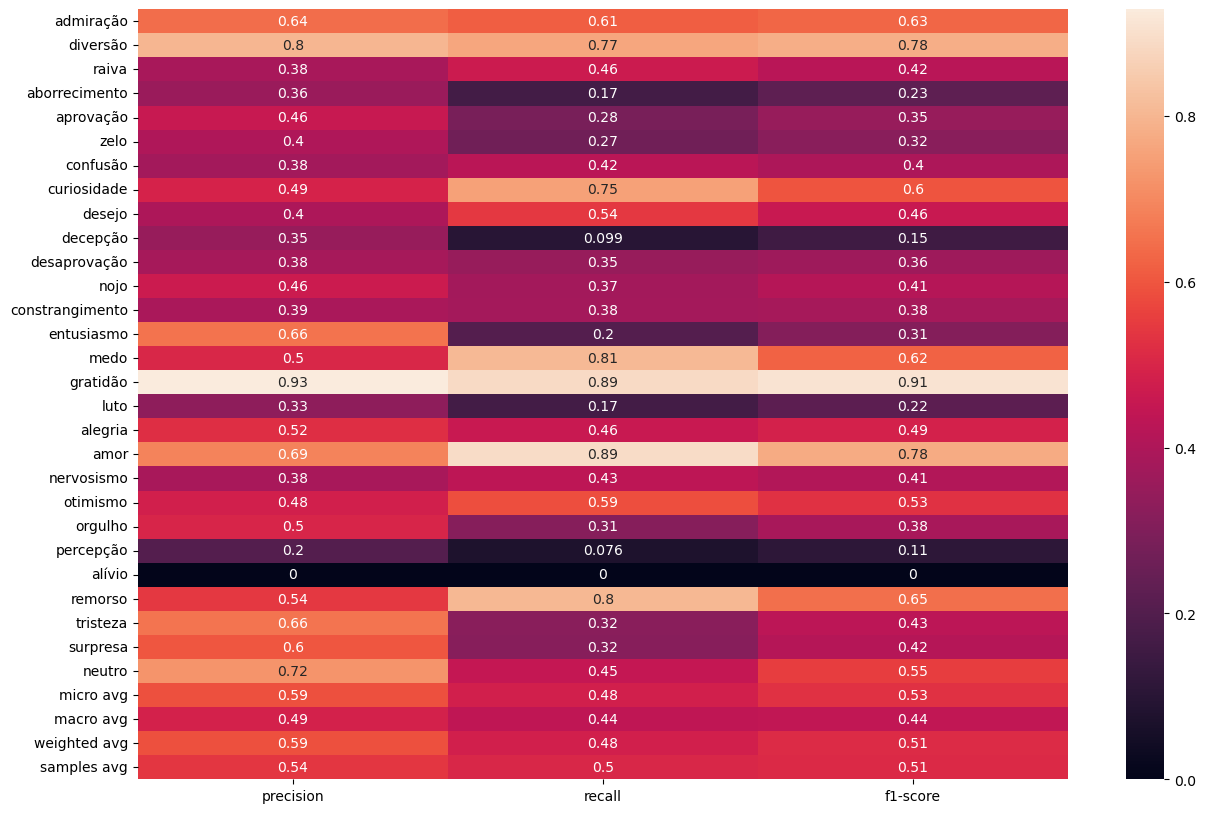

In [43]:
outside_corpus_results = classification_report(np.array(test_labels),np.array(predictions),target_names=test_labels.columns,output_dict=True,zero_division=0)

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(outside_corpus_results).iloc[:-1, :].T, annot=True)

<AxesSubplot:>

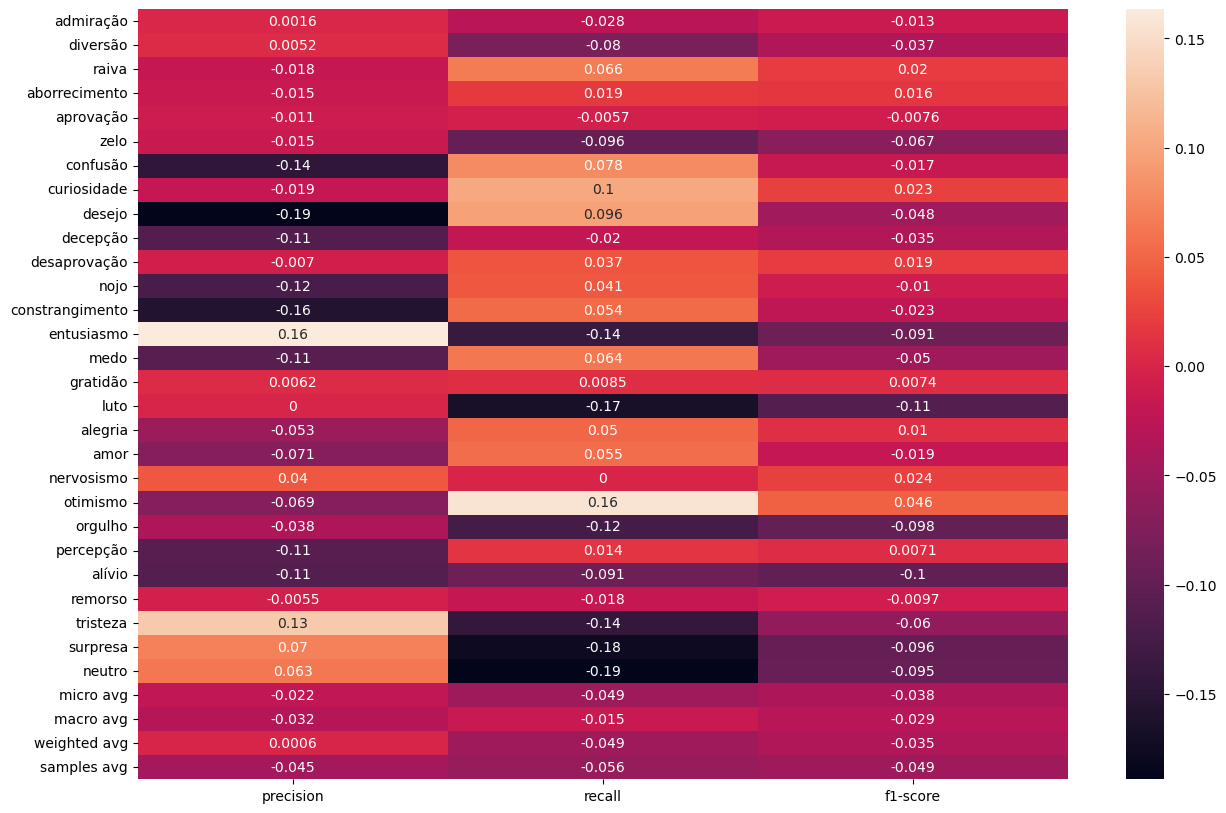

In [44]:
diff = pd.DataFrame(outside_corpus_results).iloc[:-1, :] - pd.DataFrame(clf_report).iloc[:-1, :]
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(diff).T, annot=True)

# outros conjunto: reddit + facebook neutro

In [45]:
model_name = 'neuralmind/bert-base-portuguese-cased'
student_model = transformers.BertForSequenceClassification.from_pretrained(model_name,num_labels=len(emotion_dict))
student_tokenizer = transformers.BertTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [46]:
df = pd.read_csv("features/goemotions facebook+reddit_sentences.csv")



train_inputs = df.text

train_logits = df.iloc[:,:-1]


In [47]:
student_model = student_model.to(device)

In [48]:
train_dataloader = generate_student_dataloader(train_inputs,student_tokenizer,torch.tensor(train_logits.to_numpy()),batch_size)


In [49]:
T = 3
#models parameters
transformer_vars = [i for i in student_model.parameters()]
num_train_epochs =20
#optimizer
optimizer = torch.optim.AdamW(transformer_vars, lr=learning_rate)

#loss
loss_func = torch.nn.KLDivLoss(reduction="batchmean")

#scheduler
if apply_scheduler:
  num_train_examples = len(train_inputs)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler = transformers.get_constant_schedule_with_warmup(optimizer, 
                                           num_warmup_steps = num_warmup_steps)
for epoch_i in range(num_train_epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')
    
    t0 = time.time()
    tr_loss = 0
    
    student_model.train()
    
    for step,batch in enumerate(train_dataloader):

        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[0]),max_length)
        b_teacher_logits = batch[2].to(device)/T
        
        #se der errado pode ser essa linha abaixo o problema
        model_outputs = student_model(b_input_ids,attention_mask=b_attention_mask).logits.to(device)/T
        #tem que ser log_softmax. Entender o por quê. Knowledge is power etc. etc.
        student_output = torch.nn.functional.log_softmax(model_outputs)
        teacher_output = torch.nn.functional.softmax(b_teacher_logits)
        
        batch_loss = loss_func(student_output,teacher_output)
        
        optimizer.zero_grad()
        
        batch_loss.backward()
        
        optimizer.step()
        
        tr_loss += batch_loss
        
        if apply_scheduler:
            scheduler.step()
            
    avg_train_loss = tr_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    student_model.eval()
    total_test_loss = 0
    t0 = time.time()
    
    for step,batch in enumerate(test_dataloader):
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[0]),max_length)
        b_teacher_logits = batch[2].to(device)/T
        
        with torch.no_grad():
            model_outputs = student_model(b_input_ids,attention_mask=b_attention_mask).logits.to(device)/T
            student_output = torch.nn.functional.log_softmax(model_outputs)
            teacher_output = torch.nn.functional.softmax(b_teacher_logits)
            total_test_loss += loss_func(student_output,teacher_output)
    avg_test_loss = total_test_loss / len(test_dataloader)
    
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))


======== Epoch 1 / 20 ========
Training...


/tmp/ipykernel_233579/1142844265.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(model_outputs)
/tmp/ipykernel_233579/1142844265.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Batch   100  of    146.    Elapsed: 0:00:18.
  Average training loss: 0.161
  Training epoch took: 0:00:26


/tmp/ipykernel_233579/1142844265.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  student_output = torch.nn.functional.log_softmax(model_outputs)
/tmp/ipykernel_233579/1142844265.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_output = torch.nn.functional.softmax(b_teacher_logits)


  Test Loss: 0.177
  Test took: 0:00:09

======== Epoch 2 / 20 ========
Training...
  Batch   100  of    146.    Elapsed: 0:00:18.
  Average training loss: 0.060
  Training epoch took: 0:00:26
  Test Loss: 0.084
  Test took: 0:00:09

======== Epoch 3 / 20 ========
Training...
  Batch   100  of    146.    Elapsed: 0:00:18.
  Average training loss: 0.028
  Training epoch took: 0:00:26
  Test Loss: 0.055
  Test took: 0:00:09

======== Epoch 4 / 20 ========
Training...
  Batch   100  of    146.    Elapsed: 0:00:18.
  Average training loss: 0.017
  Training epoch took: 0:00:26
  Test Loss: 0.040
  Test took: 0:00:09

======== Epoch 5 / 20 ========
Training...
  Batch   100  of    146.    Elapsed: 0:00:18.
  Average training loss: 0.012
  Training epoch took: 0:00:26
  Test Loss: 0.039
  Test took: 0:00:09

======== Epoch 6 / 20 ========
Training...
  Batch   100  of    146.    Elapsed: 0:00:18.
  Average training loss: 0.011
  Training epoch took: 0:00:26
  Test Loss: 0.037
  Test took: 0:0

In [50]:
student_model.eval()
softmax = torch.nn.Softmax()
predictions = []
for step,batch in enumerate(test_dataloader):
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[0]),max_length)
        b_teacher_logits = batch[2].to(device)
        
        with torch.no_grad():
            model_outputs = student_model(b_input_ids,attention_mask=b_attention_mask).logits.to(device)                
            for b_pred in (softmax(model_outputs).detach().cpu() > threshold):
                predictions.append(b_pred)
predictions = torch.stack(predictions) 

/tmp/ipykernel_233579/947633701.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  for b_pred in (softmax(model_outputs).detach().cpu() > threshold):


<AxesSubplot:>

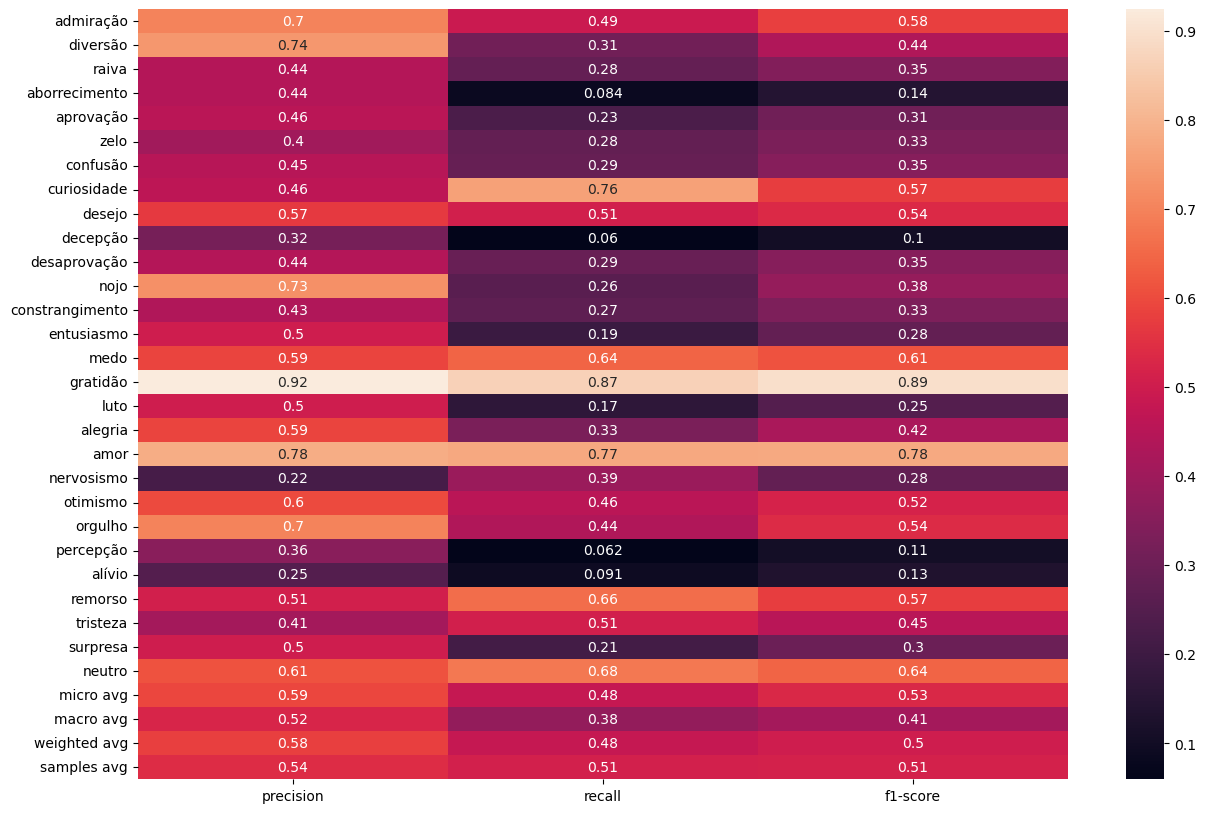

In [51]:
outside_corpus_results = classification_report(np.array(test_labels),np.array(predictions),target_names=test_labels.columns,output_dict=True,zero_division=0)

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(outside_corpus_results).iloc[:-1, :].T, annot=True)

<AxesSubplot:>

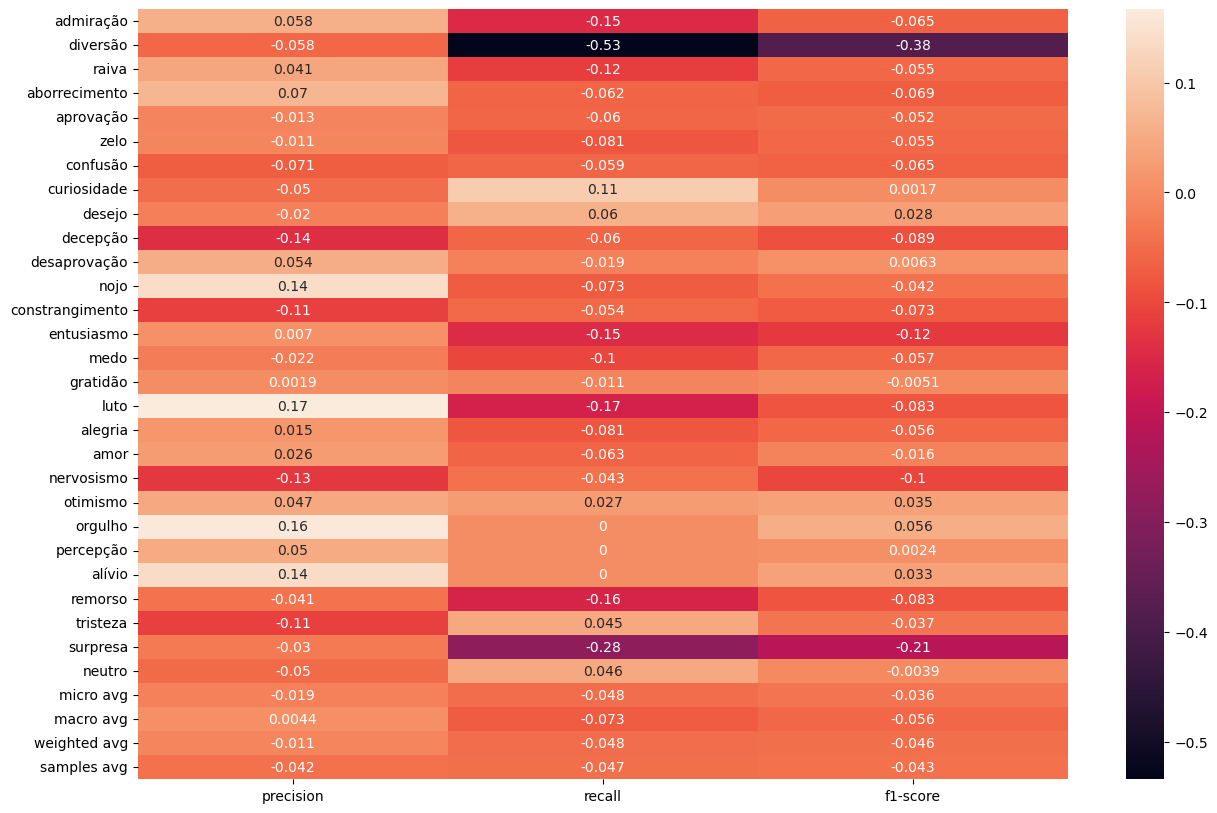

In [52]:
#pior, mas não tão pior...
#será que o problema do nosso conjunto é o tamanho dos textos?
diff = pd.DataFrame(outside_corpus_results).iloc[:-1, :] - pd.DataFrame(clf_report).iloc[:-1, :]
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(diff).T, annot=True)